In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random

# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using TensorFlow backend.


Num GPUs Available:  1


## Load Data

In [2]:
filename = 'Datasets/All_subjects_RDmap.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train1 = np.array(data["train_img"])
y_train1 = np.array(data["train_labels"])
x_test1 = np.array(data["test_img"])
y_test1 = np.array(data["test_labels"])
data.close()
print(x_train1.shape)
print(y_train1.shape)
print(x_test1.shape)
print(y_test1.shape)

Selected File: Datasets/All_subjects_RDmap.hdf5
(527, 605, 128, 128, 3)
(527, 605, 19)
(132, 605, 128, 128, 3)
(132, 605, 19)


In [3]:
filename = 'Datasets/All_subjects_RAmap.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train2 = np.array(data["train_img"])
y_train2 = np.array(data["train_labels"])
x_test2 = np.array(data["test_img"])
y_test2 = np.array(data["test_labels"])
data.close()
print(x_train2.shape)
print(y_train2.shape)
print(x_test2.shape)
print(y_test2.shape)

Selected File: Datasets/All_subjects_RAmap.hdf5
(527, 605, 128, 128, 3)
(527, 605, 19)
(132, 605, 128, 128, 3)
(132, 605, 19)


In [4]:
# windowed RD
interval = range(0,600)
x_train11 = np.reshape(x_train1[:,interval,:,:,:], (x_train1.shape[0],120,5,x_train1.shape[2],x_train1.shape[3],x_train1.shape[4]))
x_test11 = np.reshape(x_test1[:,interval,:,:,:], (x_test1.shape[0],120,5,x_test1.shape[2],x_test1.shape[3],x_test1.shape[4]))
y_train11 = np.reshape(np.argmax(y_train1[:,interval,:],-1), (y_train1.shape[0],120,5))
y_test11 = np.reshape(np.argmax(y_test1[:,interval,:],-1), (y_test1.shape[0],120,5))
y_train11 = to_categorical(np.squeeze(stats.mode(y_train11,2)[0]))
y_test11 = to_categorical(np.squeeze(stats.mode(y_test11,2)[0]))
print(x_train11.shape)
print(y_train11.shape)
print(x_test11.shape)
print(y_test11.shape)  

# windowed RA
x_train12 = np.reshape(x_train2[:,interval,:,:,:], (x_train2.shape[0],120,5,x_train2.shape[2],x_train2.shape[3],x_train2.shape[4]))
x_test12 = np.reshape(x_test2[:,interval,:,:,:], (x_test2.shape[0],120,5,x_test2.shape[2],x_test2.shape[3],x_test2.shape[4]))
y_train12 = np.reshape(np.argmax(y_train2[:,interval,:],-1), (y_train2.shape[0],120,5))
y_test12 = np.reshape(np.argmax(y_test2[:,interval,:],-1), (y_test2.shape[0],120,5))
y_train12 = to_categorical(np.squeeze(stats.mode(y_train12,2)[0]))
y_test12 = to_categorical(np.squeeze(stats.mode(y_test12,2)[0]))
print(x_train12.shape)
print(y_train12.shape)
print(x_test12.shape)
print(y_test12.shape) 

(527, 120, 5, 128, 128, 3)
(527, 120, 19)
(132, 120, 5, 128, 128, 3)
(132, 120, 19)
(527, 120, 5, 128, 128, 3)
(527, 120, 19)
(132, 120, 5, 128, 128, 3)
(132, 120, 19)


In [5]:
filename = 'Datasets/All_subjects_spectrogram.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train3 = np.array(data["train_img"])
y_train3 = np.array(data["train_labels"])
x_test3 = np.array(data["test_img"])
y_test3 = np.array(data["test_labels"])
data.close()
print(x_train3.shape)
print(y_train3.shape)
print(x_test3.shape)
print(y_test3.shape)

Selected File: Datasets/All_subjects_spectrogram.hdf5
(527, 120, 128, 128, 3)
(527, 120, 19)
(132, 120, 128, 128, 3)
(132, 120, 19)


In [6]:
filename = 'Datasets/All_subjects_margins_and_ctc_label_no_nucleus.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
margin_tr = np.array(data["train_img"])
ctc_tr = np.squeeze(np.array(data["train_labels"])).astype('U12')
margin_ts = np.array(data["test_img"])
ctc_ts = np.squeeze(np.array(data["test_labels"])).astype('U12')
data.close()
print(margin_tr.shape)
print(ctc_tr.shape)
print(margin_ts.shape)
print(ctc_ts.shape)

Selected File: Datasets/All_subjects_margins_and_ctc_label_no_nucleus.hdf5
(527, 1482)
(527,)
(132, 1482)
(132,)


In [7]:
filename = 'Datasets/All_subjects_spect_single.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train4 = np.array(data["train_img"])
x_test4 = np.array(data["test_img"])
data.close()
print(x_train4.shape)
print(x_test4.shape)

Selected File: Datasets/All_subjects_spect_single.hdf5
(527, 128, 128, 3)
(132, 128, 128, 3)


##### STA LTA

In [8]:
def sta_lta2(vec,nlta,nsta,init_th,stop_th,stepsz):
    vec2 = np.zeros(vec.shape)
    mask = np.zeros(vec.shape)
    state = 0 # '0' nothing, '1' signing
    
    for i in range(0,len(vec),stepsz):
        
        if i+nlta+nsta+1 > len(vec):
            if state == 1:
                stoppt = len(vec)-2
                vec2[startpt:stoppt] = vec[startpt:stoppt]
                mask[startpt:stoppt] = 1
            break
            
            
        longwin = vec[i:i+nlta]
        shortwin = vec[i+nlta:i+nlta+nsta]
        
        if i < nlta and np.mean(longwin) > 150:
            vec2[0:i+nsta] = vec[0:i+nsta]
            mask[0:i+nsta] = 1
        if init_th < sum(shortwin)/sum(longwin):
            if state == 0:
                startpt = i+nlta
                state = 1
            if state == 1:
                continue
        
        else:
            if state == 0:
                continue
            if state == 1:
                if sum(shortwin)/sum(longwin) > stop_th:
                    continue
                else:
                    stoppt = i+nlta+int(nsta/2)
                    state = 0
                    vec2[startpt:stoppt] = vec[startpt:stoppt]
                    mask[startpt:stoppt] = 1
                    
    return vec2, mask

In [9]:
duration = 24.2
nsta_sec = 0.7
ratio = margin_tr.shape[-1]/duration
nsta = int(nsta_sec*ratio)
nlta = int(2*nsta)
stepsz = int(0.2*ratio) # 0.2
timevec = np.linspace(0,24.2,margin_ts.shape[1])
idx = 27
init_th = 0.6
stop_th = 0.3
vecs_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
mask_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
vecs_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
mask_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
for i in range(len(margin_tr)):
    vecs_train.append(sta_lta2(margin_tr[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_train.append(sta_lta2(margin_tr[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_train_win = mask_train[:,::5]
for i in range(len(margin_ts)):
    vecs_test.append(sta_lta2(margin_ts[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_test.append(sta_lta2(margin_ts[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_test_win = mask_test[:,::5]
mask_train = np.array(mask_train)
mask_test = np.array(mask_test)

In [10]:
# downsample the mask to vid
mask_vid_tr = np.zeros(np.argmax(y_train1,-1).shape)
ratio1 = mask_train.shape[-1]/mask_vid_tr.shape[-1]
for i in range(len(mask_train)):
    for j in range(mask_train.shape[-1]):
        if mask_train[i,j] == 0:
            continue
        else:
            mask_vid_tr[i,int(j/ratio1)] = 1
mask_vid_ts = np.zeros(np.argmax(y_test1,-1).shape)
for i in range(len(mask_test)):
    for j in range(mask_test.shape[-1]):
        if mask_test[i,j] == 0:
            continue
        else:
            mask_vid_ts[i,int(j/ratio1)] = 1

# downsample the mask to spect
mask_spect_tr = np.zeros(np.argmax(y_train3,-1).shape)
ratio2 = mask_train.shape[-1]/mask_spect_tr.shape[-1]
for i in range(len(mask_train)):
    for j in range(mask_train.shape[-1]):
        if mask_train[i,j] == 0:
            continue
        else:
            mask_spect_tr[i,int(j/ratio2)] = 1
mask_spect_ts = np.zeros(np.argmax(y_test3,-1).shape)
for i in range(len(mask_test)):
    for j in range(mask_test.shape[-1]):
        if mask_test[i,j] == 0:
            continue
        else:
            mask_spect_ts[i,int(j/ratio2)] = 1
print('Mask shapes:')
print(mask_vid_tr.shape)
print(mask_vid_ts.shape)
print(mask_spect_tr.shape)
print(mask_spect_ts.shape)

Mask shapes:
(527, 605)
(132, 605)
(527, 120)
(132, 120)


In [11]:
num_class = y_test3.shape[2]
num_class

19

In [12]:
def gesture_counter(mask):
    cnt = 0
    flag = 0
    for i in range(len(mask)):
        if flag == 0 and mask[i] == 0:
            continue
        if flag == 1 and mask[i] == 1:
            continue
        if flag == 0 and mask[i] == 1:
            flag = 1
            cnt += 1
        if flag == 1 and mask[i] == 0:
            flag = 0
    return cnt

In [13]:
numgest = [gesture_counter(m) for m in mask_spect_ts]
sum(numgest)

813

In [14]:
num_class = y_test3.shape[2]
num_class

19

In [15]:
def masker(x, y, mask):
    x2 = []
    y2 = []
    flag = 0
    for i in range(len(mask)):
        for j in range(mask.shape[1]):
            if flag == 0 and mask[i,j] == 0:
                continue
            if flag == 1 and mask[i,j] == 1:
                if j == mask.shape[1]-1 and j+1 - startpt > 2:
                    stoppt = j+1
                    x2.append(x[i,startpt:stoppt])
                    y2.append(np.squeeze(np.argmax(y[i,startpt:stoppt],-1)))
                else:
                    continue
            if flag == 0 and mask[i,j] == 1:
                flag = 1
                startpt = j
            if flag == 1 and mask[i,j] == 0:
                flag = 0
                stoppt = j+1
                if stoppt-startpt > 2:
                    x2.append(x[i,startpt:stoppt])
                    y2.append(np.squeeze(np.argmax(y[i,startpt:stoppt],-1)))
    
    x2 = np.asarray(x2)
    y2 = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2)])
    return x2, y2

In [16]:
x1train, y1train = masker(x_train11, y_train3, mask_spect_tr)
x1test, y1test = masker(x_test11, y_test3, mask_spect_ts)
x2train, y2train = masker(x_train12, y_train3, mask_spect_tr)
x2test, y2test = masker(x_test12, y_test3, mask_spect_ts)
x3train, y3train = masker(x_train3, y_train3, mask_spect_tr)
x3test, y3test = masker(x_test3, y_test3, mask_spect_ts)
print(x1train.shape)
print(y1train.shape)
print(x1test.shape)
print(y1test.shape)
print(x2train.shape)
print(y2train.shape)
print(x2test.shape)
print(y2test.shape)
print(x3train.shape)
print(y3train.shape)
print(x3test.shape)
print(y3test.shape)

/home/m/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(3042,)
(3042,)
(740,)
(740,)
(3042,)
(3042,)
(740,)
(740,)
(3042,)
(3042,)
(740,)
(740,)


# CTC Model

In [17]:
characters = set(char for label in ctc_tr for char in label)
print("Number of unique characters: ", len(characters))
print("Characters present: ", sorted(characters))
print('Labels: ' + str(np.unique(ctc_tr)))
batch_size = 1

Number of unique characters:  18
Characters present:  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R']
Labels: ['ABDEFC' 'ABGHIC' 'ABJKLC' 'ABMNOC' 'ABPQRC']


In [ ]:
# Maximum length of any sequence in the dataset
max_length = max([len(label) for label in ctc_tr])

In [17]:
# Mapping characters to integers
char_to_num = experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

## Data generator

In [17]:
def encode_single_sample(data, label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"img": data, "label": label}

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train3, ctc_tr))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_test3, ctc_ts))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [17]:
def data_generator_ctc(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield [X_train, y_train], y_train

In [18]:
def data_generator_ctc_nolabel(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield X_train

In [22]:
# train_dataset = data_generator_ctc(x_train3, ctc_tr)
# validation_dataset = data_generator_ctc(x_test3, ctc_ts)
predict_generator = data_generator_ctc_nolabel(x_test3, ctc_ts)

In [132]:
print(ctc_tr[0])
print(np.array([ord(x)%32 for x in ctc_tr[0]]))

ABPQRC
[ 1  2 16 17 18  3]


# CTC

In [19]:
class CTCLayer(Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [20]:
input_shape1 = (None,x1train[0].shape[1],x1train[0].shape[2],x1train[0].shape[3],x1train[0].shape[4])
input_shape2 = input_shape1
input_shape3 = (x_train3.shape[1],x_train3.shape[2],x_train3.shape[3],x_train3.shape[4])
input_shape3

(120, 128, 128, 3)

In [25]:
def ctc_md():
    with tf.device('/gpu:2'):
        
        inputlayer3 = Input(shape = input_shape3, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer3)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(8,1)))(x)
#         x = TimeDistributed(Flatten())(x)
        new_shape = (-1, (128//2**3) *8)
        x = Reshape(target_shape=new_shape, name="reshape")(x)
#         x = Dense(64, activation="relu", name="dense1")(x)
#         x = Dropout(0.2)(x)
#         x = Bidirectional(LSTM(128, dropout=0.25, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, dropout=0.25, return_sequences=True))(x)
        
        x = Dense(len(characters) + 1, activation='softmax', name="dense2")(x)
        # Add CTC layer for calculating CTC loss at each step
        output = CTCLayer(name="ctc_loss")(labels, x)
    
        model = keras.Model(inputs = [inputlayer3, labels], outputs = [output], name="ctc_model_v1")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        
        model.compile(optimizer=opt)
        return model

In [136]:
model = ctc_md()
model.summary(line_length=125)

Model: "ctc_model_v1"
_____________________________________________________________________________________________________________________________
Layer (type)                             Output Shape               Param #        Connected to                              
image (InputLayer)                       [(None, 120, 128, 128, 3)] 0                                                        
_____________________________________________________________________________________________________________________________
time_distributed_76 (TimeDistributed)    (None, 120, 128, 128, 8)   224            image[0][0]                               
_____________________________________________________________________________________________________________________________
time_distributed_77 (TimeDistributed)    (None, 120, 64, 64, 8)     0              time_distributed_76[0][0]                 
________________________________________________________________________________________________

In [21]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

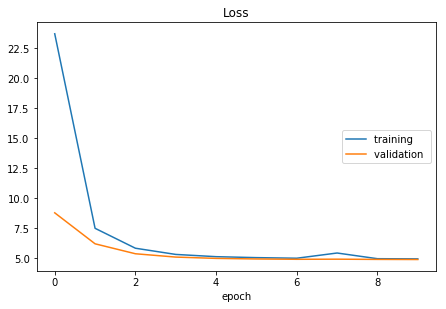

Loss
	training         	 (min:    0.028, max:   76.085, cur:    4.965)
	validation       	 (min:    1.036, max:   22.237, cur:    4.911)
527/527 [==============================] - 20s 39ms/step - loss: 4.9646 - val_loss: 4.9113
Epoch 11/100
 73/527 [===>..........................] - ETA: 13s - loss: 4.9503

KeyboardInterrupt: 

In [138]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=epochs,
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [139]:
# save model
MODEL_FILE = "Models/ctc model md no nuc.json" # save path
WEIGHT_FILE ="Models/ctc model md no nuc.h5" # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

### Predictions

In [140]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 120, 128, 128, 3) 0         
_________________________________________________________________
time_distributed_76 (TimeDis (None, 120, 128, 128, 8)  224       
_________________________________________________________________
time_distributed_77 (TimeDis (None, 120, 64, 64, 8)    0         
_________________________________________________________________
time_distributed_78 (TimeDis (None, 120, 64, 64, 8)    584       
_________________________________________________________________
time_distributed_79 (TimeDis (None, 120, 32, 32, 8)    0         
_________________________________________________________________
time_distributed_80 (TimeDis (None, 120, 32, 32, 8)    584       
_________________________________________________________________
time_distributed_81 (TimeDis (None, 120, 16, 16, 8)   

In [79]:
# pred = np.array(prediction_model.predict_generator(predict_generator, steps = len(x_test3)))
# pred.shape

In [225]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [142]:
orig_texts = []
pred_texts = []
for batch in validation_dataset.take(len(x_test3)):
    batch_images = batch["img"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts.append(decode_batch_predictions(preds))

    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

In [143]:
cmp = [pred_texts[i][0] == orig_texts[i] for i in range(len(x_test3))]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

15.909090909090908

In [144]:
idx = 2
for idx in range(len(x_test3)):
    print('Predicted: ' + pred_texts[idx][0] + ' | Original:  ' + orig_texts[idx])

Predicted: ABPQRC | Original:  ABMNOC
Predicted: ABPQRC | Original:  ABMNOC
Predicted: ABPQRC | Original:  ABJKLC
Predicted: ABPQRC | Original:  ABGHIC
Predicted: ABPEFC | Original:  ABMNOC
Predicted: ABPQRC | Original:  ABJKLC
Predicted: ABPQRC | Original:  ABDEFC
Predicted: ABPQRC | Original:  ABJKLC
Predicted: ABPQRC | Original:  ABDEFC
Predicted: ABPQRC | Original:  ABDEFC
Predicted: ABPQRC | Original:  ABGHIC
Predicted: ABPQRC | Original:  ABMNOC
Predicted: ABPQRC | Original:  ABGHIC
Predicted: ABPQRC | Original:  ABMNOC
Predicted: ABPQRC | Original:  ABDEFC
Predicted: ABPQRC | Original:  ABJKLC
Predicted: ABPQRC | Original:  ABJKLC
Predicted: ABPQRC | Original:  ABJKLC
Predicted: ABDQRC | Original:  ABPQRC
Predicted: ABPQRC | Original:  ABJKLC
Predicted: ABDQRC | Original:  ABJKLC
Predicted: ABPQRC | Original:  ABMNOC
Predicted: ABDQRC | Original:  ABMNOC
Predicted: ABPQRC | Original:  ABMNOC
Predicted: ABPQRC | Original:  ABPQRC
Predicted: ABDEFC | Original:  ABJKLC
Predicted: A

## Single image CTC

In [146]:
input_shape4 = (x_test4.shape[1],x_test4.shape[2],x_test4.shape[3])
input_shape4

(128, 128, 3)

In [189]:
def ctc_md_v2():
    with tf.device('/gpu:2'):
        
        inputlayer4 = Input(shape = input_shape4, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(inputlayer4)
        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
        x = MaxPooling2D(pool_size=(2,2))(x)
#         x = MaxPooling2D(pool_size=(8,1)))(x)
#         x = TimeDistributed(Flatten())(x)
        new_shape = (-1, (x_test4.shape[2]//2**3) * 64)
        x = Reshape(target_shape=new_shape, name="reshape")(x)
        x = Dense(64, activation="relu", name="dense1")(x)
        x = Dropout(0.2)(x)
        x = Bidirectional(LSTM(128, dropout=0.25, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, dropout=0.25, return_sequences=True))(x)
        
        x = Dense(len(characters) + 1, activation='softmax', name="dense2")(x)
        # Add CTC layer for calculating CTC loss at each step
        output = CTCLayer(name="ctc_loss")(labels, x)
    
        model = keras.Model(inputs = [inputlayer4, labels], outputs = [output], name="ctc_model_v2")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        
        model.compile(optimizer=opt)
        return model

In [1]:
model = ctc_md_v2()
model.summary(line_length=125)

NameError: name 'ctc_md_v2' is not defined

In [191]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train4, ctc_tr))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_test4, ctc_ts))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

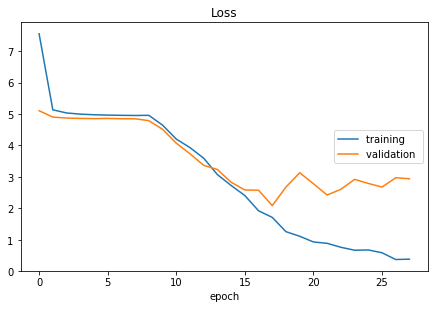

Loss
	training         	 (min:    0.028, max:   76.085, cur:    0.385)
	validation       	 (min:    1.036, max:   22.237, cur:    2.943)
527/527 [==============================] - 10s 19ms/step - loss: 0.3854 - val_loss: 2.9427


In [192]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=epochs,
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [193]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [226]:
orig_texts = []
pred_texts = []
pred = []
for batch in validation_dataset.take(len(x_test3)):
    batch_images = batch["img"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred.append(np.squeeze(np.argmax(preds,-1)))
    pred_texts.append(decode_batch_predictions(preds))

    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

In [227]:
cmp = [pred_texts[i][0] == orig_texts[i] for i in range(len(x_test3))]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
print('Sequence Accuracy (%): ' + str(acc))
# sequence prediction
for idx in range(len(x_test3)):
    print('Predicted: ' + pred_texts[idx][0] + ' | ' + orig_texts[idx] + ' :Original')

Sequence Accuracy (%): 73.48484848484848
Predicted: ABMNOC | ABMNOC :Original
Predicted: ABMNOC | ABMNOC :Original
Predicted: ABJKLC | ABJKLC :Original
Predicted: ABGHIC | ABGHIC :Original
Predicted: ABGHIC | ABMNOC :Original
Predicted: ABJKLC | ABJKLC :Original
Predicted: ABDEFC | ABDEFC :Original
Predicted: ABJKLC | ABJKLC :Original
Predicted: ABDEFC | ABDEFC :Original
Predicted: ABDEFC | ABDEFC :Original
Predicted: ABJKLC | ABGHIC :Original
Predicted: ABMNOC | ABMNOC :Original
Predicted: ABGHIC | ABGHIC :Original
Predicted: ABMNOC | ABMNOC :Original
Predicted: ABDEFC | ABDEFC :Original
Predicted: ABJKLC | ABJKLC :Original
Predicted: ABJKLC | ABJKLC :Original
Predicted: ABJKLC | ABJKLC :Original
Predicted: ABPQOC | ABPQRC :Original
Predicted: ABJKLC | ABJKLC :Original
Predicted: ABJKLC | ABJKLC :Original
Predicted: ABMNOC | ABMNOC :Original
Predicted: ABPQRC | ABMNOC :Original
Predicted: ABMNOC | ABMNOC :Original
Predicted: ABDEFC | ABPQRC :Original
Predicted: ABJKLC | ABJKLC :Origin

In [228]:
cmp = [pred_texts[i][0][j] == orig_texts[i][j] for i in range(len(x_test3)) for j in range(len(orig_texts[i]))]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
print('Elementwise Accuracy (%): ' + str(acc))
# sequence prediction
# for idx in range(len(x_test3)):
#     print('Predicted: ' + pred_texts[idx][0] + ' | Original:  ' + orig_texts[idx])

Elementwise Accuracy (%): 89.01515151515152


In [213]:
np.array(pred).shape

(132, 16)

In [221]:
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        label = label + chr(ord('@')+num)
    label = tf.strings.reduce_join(num_to_char(p)).numpy().decode("utf-8")
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[1])

AAAABBMNOCCCCCCC


In [223]:
cmp = [pred_labels[i][0] == orig_texts[i] for i in range(len(x_test3))]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
print('Sequence Accuracy (%): ' + str(acc))
# sequence prediction
for idx in range(len(x_test3)):
    print('Predicted: ' + pred_labels[idx] + ' | ' + orig_texts[idx] + ' :Original')

Sequence Accuracy (%): 0.0
Predicted: AAAABBMNOCCCCCCC | ABMNOC :Original
Predicted: AAAABBMNOCCCCCCC | ABMNOC :Original
Predicted: AAAABBJKLCCCCCCC | ABJKLC :Original
Predicted: AAAABBGHICCCCCCC | ABGHIC :Original
Predicted: AAAAABGHICCCCCCC | ABMNOC :Original
Predicted: AAAABBJKLCCCCCCC | ABJKLC :Original
Predicted: AAAABBDEFCCCCCCC | ABDEFC :Original
Predicted: AAAABBJKLCCCCCCC | ABJKLC :Original
Predicted: AAAABBDEFCCCCCCC | ABDEFC :Original
Predicted: AAABBBDEFCCCCCCC | ABDEFC :Original
Predicted: AAAABBJKLCCCCCCC | ABGHIC :Original
Predicted: AAAABBMNOCCCCCCC | ABMNOC :Original
Predicted: AAABBBGHICCCCCCC | ABGHIC :Original
Predicted: AAAABBMNOCCCCCCC | ABMNOC :Original
Predicted: AAAABBDEFCCCCCCC | ABDEFC :Original
Predicted: AAAABBJKLCCCCCCC | ABJKLC :Original
Predicted: AAAABBJKLCCCCCCC | ABJKLC :Original
Predicted: AAAABBJKLCCCCCCC | ABJKLC :Original
Predicted: AAAABBPQOCCCCCCC | ABPQRC :Original
Predicted: AAAABBJKLCCCCCCC | ABJKLC :Original
Predicted: AAAABBJKLCCCCCCC | ABJ

In [197]:
# save model
MODEL_FILE = "Models/ctc model md no nuc single spec.json" # save path
WEIGHT_FILE ="Models/ctc model md no nuc single spec.h5" # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

# Train/Test with detected samples

In [22]:
def num_to_ch(num):
    label = ''
    for ch in num:
        label += chr(ord('@') + np.argmax(ch,-1)+1)
    return label

In [23]:
# convert detected labels
ctc_tr3 = [num_to_ch(y) for y in y3train]
ctc_ts3 = [num_to_ch(y) for y in y3test]

In [36]:
characters3 = set(char for label in ctc_tr3 for char in label)
print("Number of unique characters: ", len(characters3))
print("Characters present: ", sorted(characters3))
# print('Labels: ' + str(np.unique(ctc_tr3)))
batch_size = 1

Number of unique characters:  19
Characters present:  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S']


In [37]:
train_dataset = data_generator_ctc(x1train, ctc_tr3)
validation_dataset = data_generator_ctc(x1test, ctc_ts3)
predict_generator = data_generator_ctc_nolabel(x1test, ctc_ts3)

In [38]:
input_shape33 = (None,x3train[0].shape[1],x3train[0].shape[2],x3train[0].shape[3])
input_shape_vid = (None,x1train[0].shape[1],x1train[0].shape[2],x1train[0].shape[3],x1train[0].shape[4])
input_shape_vid

(None, 5, 128, 128, 3)

In [39]:
def ctc_md3():
    with tf.device('/gpu:2'):
        
        inputlayer3 = Input(shape = input_shape33, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer3)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(4,1)))(x)
#         x = TimeDistributed(Flatten())(x)
        new_shape = (-1, (128//2**3) *64)
        x = Reshape(target_shape=new_shape, name="reshape")(x)
        x = Dense(64, activation="relu", name="dense1")(x)
        x = Dropout(0.5)(x)
#         x = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(x)
        
        x = Dense(len(characters3) + 2, activation='softmax', name="dense2")(x)
        # Add CTC layer for calculating CTC loss at each step
        output = CTCLayer(name="ctc_loss")(labels, x)
    
        model = keras.Model(inputs = [inputlayer3, labels], outputs = [output], name="ctc_model_v1")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        
        model.compile(optimizer=opt)
        return model

In [40]:
def ctc_rd():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape_vid, name="rd")
#         inputlayer2 = Input(shape = input_shape_vid, name="ra")
#         inputlayer3 = Input(shape = input_shape, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(x)
        new_shape = (-1, (128//2**3) *64 *5)
        cnv1 = Reshape(target_shape=new_shape, name="reshape")(x)
        cnv1 = Dense(64, activation="relu", name="dense1")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
        
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        model = keras.Model(inputs = [inputlayer, labels], outputs = [out_ctc], name="ctc_model_v1")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        
        model.compile(optimizer=opt)
        
        return model

In [41]:
model33 = ctc_rd()
# model33.summary(line_length=120)

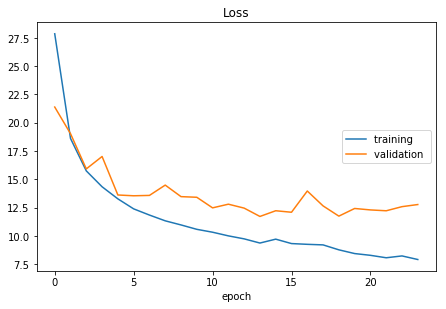

Loss
	training         	 (min:    7.905, max:   27.867, cur:    7.905)
	validation       	 (min:   11.714, max:   21.390, cur:   12.767)
3042/3042 [==============================] - 166s 55ms/step - loss: 7.9048 - val_loss: 12.7671


In [42]:
history = model33.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x3train), validation_steps = len(x3test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [44]:
# Get the prediction model by extracting layers till the output layer
prediction_model33 = keras.models.Model(
    model33.get_layer(name="rd").input, model33.get_layer(name="dense2").output
)
# prediction_model.summary()

In [45]:
pred = [np.argmax(np.squeeze(prediction_model33.predict(next(predict_generator))),-1) for i in range(len(x3test))]

In [46]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

CCCCCCCCC


In [47]:
# for idx in range(len(ctc_ts3)):
#     print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

In [48]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts3]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [49]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

77.16216216216216

In [50]:
# save model
MODEL_FILE = "Models/ctc model rd GD.json" # save path
WEIGHT_FILE ="Models/ctc model rd GD.h5" # save path

model_json = model33.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model33.save_weights(WEIGHT_FILE)

In [105]:
model_addr = 'Models/ctc model md no nuc GD td spec.json'
weight_addr = 'Models/ctc model md no nuc GD td spec.h5'
json_file = open(model_addr, 'r')
loaded_model_json = json_file.read()
json_file.close()
model33 = model_from_json(loaded_model_json, custom_objects={'CTCLayer': CTCLayer})
model33.load_weights(weight_addr)

# Fusion

In [24]:
def data_generator_multi_rd(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3, y_train], y_train

In [27]:
def data_generator_multi_rd_nolabel(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3]

In [28]:
train_dataset = data_generator_multi_rd([x1train, x2train, x3train], 
                                     ctc_tr3)
validation_dataset = data_generator_multi_rd([x1test, x2test, x3test], 
                                     ctc_ts3)
predict_generator = data_generator_multi_rd_nolabel([x1test, x2test, x3test])

In [73]:
model_file = 'Models/ctc model rd GD.json'
w_file = 'Models/ctc model rd GD.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_rd = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model_rd.load_weights(w_file)

In [74]:
model_file = 'Models/ctc model ra GD.json'
w_file = 'Models/ctc model ra GD.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_ra = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model_ra.load_weights(w_file)

In [75]:
model_file = 'Models/ctc model md no nuc GD td spec.json'
w_file = 'Models/ctc model md no nuc GD td spec.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_md = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model_md.load_weights(w_file)

In [76]:
# rename layers
# model_ra.get_layer('reshape')._name = model_ra.get_layer('reshape').name + '_2'
# model_md.get_layer('reshape')._name = model_md.get_layer('reshape').name + '_3'
# model_ra.get_layer('dense1')._name = model_ra.get_layer('dense1').name + '_2'
# model_md.get_layer('dense1')._name = model_md.get_layer('dense1').name + '_3'
# model_rd.get_layer('time_distributed')._name = model_rd.get_layer('time_distributed').name + '_rd'
for layers in model_rd.layers:
    layers._name = layers.name + '_rd'
for layers in model_ra.layers:
    layers._name = layers.name + '_ra'
for layers in model_md.layers:
    layers._name = layers.name + '_md'
# model_md.get_layer('time_distributed')._name = model_md.get_layer('time_distributed').name + '_3'

In [77]:
for layer in model_rd.layers:
    print(layer.name)

rd_rd
time_distributed_rd
time_distributed_1_rd
time_distributed_2_rd
time_distributed_3_rd
time_distributed_4_rd
time_distributed_5_rd
time_distributed_6_rd
reshape_rd
dense1_rd
dropout_rd
bidirectional_rd
label_rd
dense2_rd
ctc_loss_rd


In [78]:
merged_layers = concatenate([model_rd.layers[-4].output,model_ra.layers[-4].output,model_md.layers[-4].output])
x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(merged_layers)
labels = Input(name="label", shape=(None,))#, dtype="float32")
out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
opt = Adam(lr=1e-3, decay=1e-3 / 200)  
model_multi = keras.Model(inputs = [model_rd.get_layer('rd_rd').input, model_ra.get_layer('ra_ra').input, model_md.get_layer('image_md').input, labels], 
                            outputs = out_ctc, 
                           name="ctc_model")
model_multi.compile(optimizer=opt)

In [79]:
# Freeze the layers except the last 7 layers
# for layer in model_multi.layers[:-2]:
#     layer.trainable = False

# Check the trainable status of the individual layers
# for layer in model_multi.layers:
#     print(layer, layer.trainable)

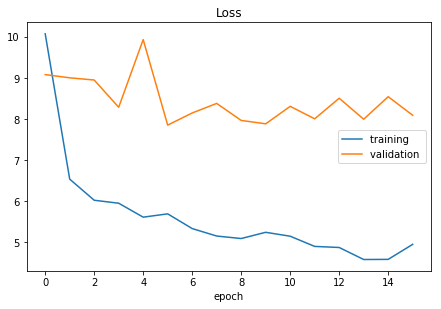

Loss
	training         	 (min:    4.579, max:   10.072, cur:    4.949)
	validation       	 (min:    7.850, max:    9.931, cur:    8.090)
3042/3042 [==============================] - 344s 113ms/step - loss: 4.9486 - val_loss: 8.0896


In [80]:
history = model_multi.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x3train), validation_steps = len(x3test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [81]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    [model_multi.get_layer(name="rd_rd").input, model_multi.get_layer(name="ra_ra").input, model_multi.get_layer(name="image_md").input], model_multi.get_layer(name="dense2").output
)
# prediction_model.summary()

In [82]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x3test))]

In [83]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

CCCCCCCCCCCCCCAA


In [84]:
# for idx in range(len(ctc_ts3)):
#     print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

In [85]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts3]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [86]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

89.45945945945945

# Stateful LSTM + CTC

In [42]:
x4train = np.array([t for x3 in x3train for t in x3])
print(x4train.shape)
x4test = np.array([t for x3 in x3test for t in x3])
print(x4test.shape)
ctc_tr4 = np.array([t for x3 in ctc_tr3 for t in x3])
print(ctc_tr4.shape)
ctc_ts4 = np.array([t for x3 in ctc_ts3 for t in x3])
print(ctc_ts4.shape)
y4train = np.array([t for x3 in y3train for t in x3])
print(y4train.shape)
y4test = np.array([t for x3 in y3test for t in x3])
print(y4test.shape)

(15572, 128, 128, 3)
(3658, 128, 128, 3)
(15572,)
(3658,)
(15572, 19)
(3658, 19)


In [20]:
characters4 = set(char for label in ctc_tr4 for char in label)
print("Number of unique characters: ", len(characters4))
print("Characters present: ", sorted(characters4))
# print('Labels: ' + str(np.unique(ctc_tr3)))
batch_size = 1
from collections import Counter
print(Counter(ctc_tr4))

Number of unique characters:  19
Characters present:  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S']
Counter({'B': 4441, 'A': 2467, 'C': 1718, 'D': 1570, 'I': 413, 'M': 403, 'J': 382, 'L': 376, 'S': 375, 'P': 366, 'O': 360, 'F': 356, 'K': 355, 'G': 355, 'R': 353, 'H': 349, 'E': 328, 'Q': 327, 'N': 278})


In [40]:
def data_generator(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(label[i])

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield X_train, y_train

In [27]:
def data_generator_state(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield X_train, y_train

In [29]:
def data_generator_state_nolabel(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield X_train

In [92]:
train_dataset = data_generator_state(x4train, ctc_tr4)
validation_dataset = data_generator_state(x4test, ctc_ts4)
predict_generator = data_generator_state_nolabel(x4test, ctc_ts4)

In [93]:
input_shape4 = (1,x4train.shape[1],x4train.shape[2],x4train.shape[3])
input_shape5 = (x4train.shape[1],x4train.shape[2],x4train.shape[3])
input_shape5

(128, 128, 3)

In [98]:
def ctc_md_stateful():
    with tf.device('/gpu:2'):
        
#         inputlayer3 = Input(batch_shape = input_shape4, name="image")
        inputlayer3 = Input(shape = input_shape5, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(inputlayer3)
        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
        x = MaxPooling2D(pool_size=(2,2))(x)
        x = MaxPooling2D(pool_size=(4,1))(x)
#         x = TimeDistributed(Flatten())(x)
        new_shape = (-1, 64)
        x = Reshape(target_shape=new_shape, name="reshape")(x)
        x = Dense(64, activation="relu", name="dense1")(x)
        x = Dropout(0.5)(x)
#         x = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True, stateful = False))(x)
    
        x = Dense(len(characters4) + 1, activation='softmax', name="dense2")(x)
        output = CTCLayer(name="ctc_loss")(labels, x)
#         soft = Dense(19, activation='softmax', name="dense2")(x)
        model = keras.Model(inputs = [inputlayer3, labels], outputs = [output], name="ctc_model_v1")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        
        model.compile(optimizer=opt) #, loss = 'categorical_crossentropy', metrics = ['accuracy'])
        return model

In [105]:
model_state = ctc_md_stateful()
model_state.summary(line_length=120)

Model: "ctc_model_v1"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
image (InputLayer)                     [(None, 128, 128, 3)]      0                                                     
________________________________________________________________________________________________________________________
conv2d_63 (Conv2D)                     (None, 128, 128, 32)       896           image[0][0]                             
________________________________________________________________________________________________________________________
max_pooling2d_77 (MaxPooling2D)        (None, 64, 64, 32)         0             conv2d_63[0][0]                         
________________________________________________________________________________________________________________________
conv2d_64 

In [100]:
epochs = 100
early_stopping_patience = 5
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

In [101]:
history = model_state.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x4train), validation_steps = len(x4test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

Epoch 1/100


AssertionError: in user code:

    /home/m/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/m/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/m/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/m/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/m/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/m/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/m/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /home/m/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/m/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /home/m/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:517 _run_internal_graph
        assert x_id in tensor_dict, 'Could not compute output ' + str(x)

    AssertionError: Could not compute output Tensor("ctc_loss/ctc_loss_6/Identity:0", shape=(None, 64, 20), dtype=float32)


In [36]:
# Get the prediction model by extracting layers till the output layer
prediction_model4 = keras.models.Model(
    model_state.get_layer(name="image").input, model_state.get_layer(name="dense2").output
)
# prediction_model.summary()

In [37]:
pred = [np.argmax(np.squeeze(prediction_model4.predict(next(predict_generator))),-1) for i in range(len(x4test))]

In [38]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

In [42]:
for idx in range(200): #range(len(ctc_ts4)):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts4[idx] + ' :Original')

1. Predicted:  | A :Original
2. Predicted:  | A :Original
3. Predicted:  | A :Original
4. Predicted:  | B :Original
5. Predicted:  | B :Original
6. Predicted:  | B :Original
7. Predicted:  | B :Original
8. Predicted:  | B :Original
9. Predicted:  | B :Original
10. Predicted:  | B :Original
11. Predicted:  | B :Original
12. Predicted:  | B :Original
13. Predicted:  | B :Original
14. Predicted:  | B :Original
15. Predicted:  | B :Original
16. Predicted:  | B :Original
17. Predicted:  | B :Original
18. Predicted:  | B :Original
19. Predicted:  | B :Original
20. Predicted:  | B :Original
21. Predicted:  | B :Original
22. Predicted:  | B :Original
23. Predicted:  | B :Original
24. Predicted:  | B :Original
25. Predicted:  | B :Original
26. Predicted:  | B :Original
27. Predicted:  | B :Original
28. Predicted:  | B :Original
29. Predicted:  | B :Original
30. Predicted:  | B :Original
31. Predicted:  | B :Original
32. Predicted:  | A :Original
33. Predicted:  | C :Original
34. Predicted:  | C

In [40]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts4]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [41]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts4)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

15.527610716238382

In [104]:
# save model
MODEL_FILE = "Models/ctc stateful md.json" # save path
WEIGHT_FILE ="Models/ctc stateful md.h5" # save path

model_json = model33.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model33.save_weights(WEIGHT_FILE)

'B'